In [1]:
import pandas as pd
import numpy as np
import csv
import time
import pickle
from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn import svm
from pymatbridge import Matlab
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from __future__ import division
from collections import Counter
from scipy.stats import sem
from scipy.io import savemat

In [78]:
#creat labels for data
def add_Names(filename, selected_features):
    # Start with an empty dictionary
    stats = {}
    for line in open(filename):
        # Split the config.dat file with delimiter ','; key is the feature number and value is feature name
        line = line.replace("'", "")
        temp = line.rstrip().split(',')
        stats[temp[0]] = temp[1]
    features = []
    for feature in selected_features:
        features.append(stats[str(feature)])
    features.append(class_label)
    return features

#Select data based on objects' labels (subset for certain classes)
def selectdata(data, Selected_Class):
    dataF = pd.DataFrame()
    i = 0
    for c in Selected_Class:
        dataF =  dataF.append(data[data[class_label] == c])
        #dataF.loc[data[class_label] == c,class_label] = i
        i+=1
    return dataF

def normalize_data_with_label(data):
    df = data.iloc[:,range(0,len_feature)]
    data_norm = (df - df.mean()) / (df.max() - df.min())
    data_norm[class_label] = data[class_label]
    return data_norm

#minus mean and divided by standard deviation
def normalize_data_with_label2(data):
    df = data.iloc[:,range(0,len_feature)]
    data_norm = (df - df.mean()) / df.std()
    data_norm[class_label] = data[class_label]
    return data_norm

def sample_wo_replacement(data, size, Selected_Class):
    o_data = pd.DataFrame()
    for c in Selected_Class:
        temp = data[data[class_label] == c]
        class_size = len(temp)
        if size > class_size:
            indexes = np.random.choice(temp.index, size-class_size, replace=True)
            temp = temp.append(temp.ix[indexes])
        else:
            indexes = np.random.choice(temp.index, size, replace=False)
            temp = temp.ix[indexes]
        o_data = o_data.append(temp)
    return o_data

def sample_wo_replacement_by_ratio(data, ratio, Selected_Class):
    o_data = pd.DataFrame()
    for c in Selected_Class:
        temp = data[data[class_label] == c]
        class_size = len(temp)
        if ratio > 1:
            indexes = np.random.choice(temp.index, class_size*(ratio-1), replace=True)
            temp = temp.append(temp.ix[indexes])
        else:
            indexes = np.random.choice(temp.index, class_size*ratio, replace=False)
            temp = temp.ix[indexes]
        o_data = o_data.append(temp)
    return o_data

In [92]:
def format_data(source_dec, target_dec, Selected_pair):
    '''determine the size of the smaller class'''
    
    target_smaller_class  = 99999999
    target_bigger_class  = -99999999
    
    source_smaller_class  = 99999999
    source_bigger_class  = -99999999
    
    larger_c_target = -1
    larger_c_source = -1
    
    for data, flag in [(source_dec, False), (target_dec, True)]:
        newdata = pd.DataFrame()
        i = 1
        for c in Selected_pair:
            selection = (data[class_label] == c)
            temp = data[selection]
            temp.loc[:,class_label] = i
            newdata = newdata.append(temp)            
            if flag:
                if (len(temp) < target_smaller_class):
                    target_smaller_class  = len(temp)
                if (len(temp) > target_bigger_class):
                    target_bigger_class  = len(temp)
                    larger_c_target = i
            if not flag:
                if (len(temp) < source_smaller_class):
                    source_smaller_class  = len(temp)
                if (len(temp) > source_bigger_class):
                    source_bigger_class  = len(temp)
                    larger_c_source = i
            i = i-2
        if flag:
            target_dec = newdata
        else:
            source_dec = newdata
        
    '''determine how many partitions shall we split the larger group'''
    ratio_target = target_bigger_class//target_smaller_class
    ratio_source = source_bigger_class//source_smaller_class
    target_replace_flag = False
    source_replace_flag = False
    '''make sure that we at least have min_iter_times partitions and at most have max_iter_times'''
    if ratio_target > max_iter_times:
        ratio_target = max_iter_times
    elif ratio_target < min_iter_times:
        ratio_target = min_iter_times
        target_replace_flag = True
    if ratio_source > max_iter_times:
        ratio_source = max_iter_times
    elif ratio_source < min_iter_times:
        ratio_source = min_iter_times
        source_replace_flag = True
    '''Partition target data'''
    re_target = []
    for k in range(ratio_target):
        temp_target = sample_wo_replacement(target_dec, target_smaller_class, [1, -1])
        if not target_replace_flag:
            index_del_target = (temp_target[temp_target[class_label] == larger_c_target]).index.values
            target_dec = target_dec[~target_dec.index.isin(index_del_target)]
        re_target.append(temp_target)
    '''Partition source data''' 
    re_source = []
    for k in range(ratio_source):
        temp_source = sample_wo_replacement(source_dec, source_smaller_class, [1, -1])
        if not source_replace_flag:
            index_del_source = (temp_source[temp_source[class_label] == larger_c_source]).index.values
            source_dec = source_dec[~source_dec.index.isin(index_del_source)]
        re_source.append(temp_source)
    return re_source, re_target, target_smaller_class, ratio_target, ratio_source, larger_c_target

In [97]:
len(re_source[0])

9366

In [87]:
target_smaller_class

1695

In [94]:
re_source, re_target, target_smaller_class, ratio_target, ratio_source, larger_c_target = format_data(
    crts, ptfr, Selected_pairs[0])

In [22]:
max_iter_times = 10
min_iter_times = 2

In [101]:
'''formulate data for CODA'''
def CODA(source, target, tr_ratio, un_ration, test_ratio, test_smaller_class, larger_c, mlab):
    #Note! since Matlab index starts at 1, count always equal to len(dataX)+1
    count = 1
    Selected_Class = [1,-1]
    dataLabSS = source
    dataLabTT = sample_wo_replacement(target, test_smaller_class*tr_ratio, Selected_Class)
    idxSS = range(count,(len(dataLabSS)+count))

    temp = target[target.index.isin(dataLabTT.index.values)]
    temp = temp[temp[class_label] == larger_c]
    
    dataX = dataLabSS.append(dataLabTT)
    idxLabs = range(count,(len(dataX)+count))
    count = len(dataX)+count

    target_remain = target[~target.index.isin(dataLabTT.index.values)]
    dataUnls = sample_wo_replacement(target_remain, test_smaller_class*un_ration, Selected_Class)
    idxUnls = range(count,(len(dataUnls)+count))
    count = len(dataUnls)+count
    dataX = dataX.append(dataUnls)

    target_remain = target_remain[~target_remain.index.isin(dataUnls.index.values)]
    #use imbalanced test data
    dataTest = sample_wo_replacement_by_ratio(target_remain, test_ratio, Selected_Class)
    idxTest = range(count,(len(dataTest)+count))
    count = len(dataTest)+count  
    dataX = dataX.append(dataTest)
    idxTT = range(len(dataLabSS)+1,len(dataX)+1)

    labels = dataX[class_label].values
    dataX_norm1 = normalize_data_with_label(dataX)
    dataX_norm1 = np.array(dataX_norm1.iloc[:,range(0,len_feature)])
    res = mlab.run_func('coda_setup_modified.m', {'arg1': dataX_norm1.T, 'arg2': labels, 
                               'arg3': idxLabs, 'arg4':idxUnls, 'arg5':idxTest, 
                               'arg6': idxSS, 'arg7': idxTT})
    pred = (res['result'])[0]
    acc_CODA = pred[len(pred)-1]
    pred = pred[:(len(pred)-1)]
    return acc_CODA, dataX_norm1, labels, idxLabs, idxUnls, idxTest, dataLabTT, pred

In [5]:
def GFK_RF(dataX_norm1, labels, idxLabs, idxUnls, idxTest, dataLabTT, mlab):
    dataLabTT = normalize_data_with_label(dataLabTT)
    idxLabs = np.array(idxLabs) 
    idxTest = np.array(idxTest) 
    idxUnls = np.array(idxUnls)
    Xs = dataX_norm1[idxLabs - 1]  
    Ys = labels[idxLabs - 1]    
    pca.fit(Xs)  
    Ps = pca.components_# source subspace
    Xt = dataX_norm1[idxTest - 1]
    Yt = labels[idxTest - 1]             
    pca.fit(Xt)  
    Pt = pca.components_# target subspace

    Ps = Ps.T
    Pt = Pt.T
    #print "running gfk"
    res = mlab.run_func('GFK_modified.m', {'arg1': Ps, 'arg2': Pt[:,0:10]})
    G = res['result']
    #print "end running gfk ", mlab_run_time
    XsG = np.matrix(Xs)*np.matrix(G)
    XtG = np.matrix(Xt)*np.matrix(G)
    withG_scores = []
    woG_scores = []
    T2T_scores = []
    target_tr_y = dataLabTT[class_label].values
    target_tr_X = np.array(dataLabTT.iloc[:,range(0,len_feature)])
    
    Y_pred_GFK = []
    Y_pred_RF = []
    Y_pred_T2T = []
    fimp_GFK = []
    fimp_RF = []
    fimp_T2T = []
    for i in range(iter_time1):
        clf.fit(XsG, Ys)
        score = clf.score(XtG, Yt)
        withG_scores.append(score)
        Y_pred_GFK.extend(clf.predict(XtG))
        fimp_GFK.append(clf.feature_importances_)
        
        clf.fit(Xs, Ys)
        score = clf.score(Xt, Yt)
        woG_scores.append(score)
        Y_pred_RF.extend(clf.predict(Xt))
        fimp_RF.append(clf.feature_importances_)
        
        clf.fit(target_tr_X, target_tr_y)
        score = clf.score(Xt, Yt)
        T2T_scores.append(score)
        Y_pred_T2T.extend(clf.predict(Xt))
        fimp_T2T.append(clf.feature_importances_)
        
    acc_GFK = np.mean(withG_scores)
    acc_RF = np.mean(woG_scores)
    acc_T2T = np.mean(T2T_scores)
    return acc_GFK, acc_RF, acc_T2T, Y_pred_GFK, Y_pred_RF, Y_pred_T2T, \
np.mean(fimp_GFK, axis=0), np.mean(fimp_RF, axis=0), np.mean(fimp_T2T, axis=0)

In [6]:
def plot_confusion_matrix(cm, filename, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(Selected_Class))
    plt.xticks(tick_marks, Selected_Class, rotation=45)
    plt.yticks(tick_marks, Selected_Class)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i, cas in enumerate(cm):
        for j, c in enumerate(cas):
            plt.text(j-.15, i+.05, round(c,3), fontsize=14, color='coral')
    plt.savefig('Normalized_CM/%s'%filename, bbox_inches='tight')

In [7]:
selected_features = range(1,22)
selected_features.remove(15)
Selected_Class = [1,2,4,5,6,8] 
len_feature = len(selected_features)
class_label = "class"
filename = 'config.dat'
feature_labels = add_Names(filename,selected_features)

In [8]:
crts = pd.read_csv('../ML_DA/CSDR2_lc_data.csv')
ptfr = pd.read_csv('../ML_DA/R_PTF_lc_features.csv')
lineardb = pd.read_csv('../ML_DA/Linear_lc_over40.csv')

In [9]:
print "Class distribution among these surveys"
print "CSDR2: ", Counter(crts[class_label])
print "PTFr: ", Counter(ptfr[class_label])
print "lineardb: ", Counter(lineardb[class_label])

Class distribution among these surveys
CSDR2:  Counter({1: 30745, 5: 5466, 2: 4683, 4: 2431, 8: 1521, 13: 512, 6: 502})
PTFr:  Counter({1: 10365, 5: 1990, 2: 1695, 4: 649, 8: 522, 6: 169, 13: 68})
lineardb:  Counter({1: 6537, 5: 2080, 2: 1200, 4: 672, 8: 369, 6: 217, 13: 128})


In [10]:
svc = LinearSVC()
rfc = RandomForestClassifier()
pca = PCA()

In [11]:
#generate selected pairs
Selected_pairs = []
for i in range(len(Selected_Class)):
    for j in range(i+1, len(Selected_Class)):
        Selected_pairs.append([Selected_Class[i],Selected_Class[j]])

----------------------------------------Data Preparation-----------------------------------------------

In [98]:
scores_per_pair = []
errorbars_per_pair = []
Y_preds_pairs = []
Y_tests_pairs = []
feature_importance_per_pair = []

In [99]:
mlab = Matlab(executable='/Applications/MATLAB_R2015a.app/bin/matlab')

In [107]:
Selected_Class = [1, -1]
tr_ratio = 0.1
un_ration = 0.7
test_ratio = 0.2
iter_time1 = 4
iter_time2 = 2
clf = rfc
mlab.start()
mlab_run_time = 0
for Selected_pair in Selected_pairs[0:1]:
    print Selected_pair
    scores_per_DA = []
    errorbars = []
    
    Y_preds_CODA = [] 
    Y_preds_GFK = [] 
    Y_preds_RF = [] 
    Y_preds_T2T = []
    Y_tests = []
    F_importance_GFK = []
    F_importance_RF = []
    F_importance_T2T = []
    for source, target in [(crts, ptfr)]:
        source = selectdata(source, Selected_pair)
        target = selectdata(target, Selected_pair)
        '''format source and target data, get num of smaller class, determine how many times shall we repeat (ratio)'''
        source_set, target_set, target_smaller_class, ratio_target, ratio_source, larger_c_target = format_data(
            source, target, Selected_pair)
        scores_CODA = []
        scores_GFK = []
        scores_RF = []
        scores_T2T = []
        fimp_GFKs = []
        fimp_RFs = []
        fimp_T2Ts = []
        for i in range(ratio_source):
            source = source_set[i]
            for j in range(ratio_target):
                target = target_set[j]
                '''Results for CODA'''
                acc_CODA, dataX_norm1, labels, idxLabs, idxUnls, idxTest, \
                dataLabTT, Y_pred_CODA = CODA(
                    source, target, tr_ratio, un_ration, test_ratio, target_smaller_class, 
                    larger_c_target, mlab)
                mlab_run_time = mlab_run_time+1           
                scores_CODA.append(acc_CODA)
                print mlab_run_time

                '''The results using the same data using GFK and random forest'''
                acc_GFK, acc_RF, accT2T, Y_pred_GFK, Y_pred_RF, Y_pred_T2T, fimp_GFK, fimp_RF, fimp_T2T = GFK_RF(
                    dataX_norm1, labels, idxLabs, idxUnls, idxTest, dataLabTT, mlab)
                mlab_run_time = mlab_run_time+1
                scores_GFK.append(acc_GFK)
                scores_RF.append(acc_RF)
                scores_T2T.append(accT2T)

                fimp_GFKs.append(fimp_GFK)
                fimp_RFs.append(fimp_RF)
                fimp_T2Ts.append(fimp_T2T)
                mlab.stop()
                mlab.start()
                errorbars.append([scores_CODA, scores_GFK, scores_RF, scores_T2T])
                scores_per_DA.append([1-np.mean(scores_CODA), np.mean(scores_GFK), np.mean(scores_RF), np.mean(scores_T2T)])
                F_importance_GFK.append(fimp_GFKs)
                F_importance_RF.append(fimp_RFs)
                F_importance_T2T.append(fimp_T2Ts)
                
            idxTest = np.array(idxTest) 
            Y_preds_GFK.extend(Y_pred_GFK)
            Y_preds_RF.extend(Y_pred_RF)
            Y_preds_T2T.extend(Y_pred_T2T)    
            Y_test = labels[idxTest - 1]
            for k in range(ratio_source):
                Y_tests.extend(Y_test)
                Y_preds_CODA.extend(Y_pred_CODA)
    Y_preds_pairs.append([Y_preds_CODA, Y_preds_GFK, Y_preds_RF, Y_preds_T2T])
    Y_tests_pairs.append(Y_tests)
    scores_per_pair.append(scores_per_DA)
    errorbars_per_pair.append(errorbars)
    feature_importance_per_pair.append([F_importance_GFK, F_importance_RF, F_importance_T2T])
mlab.stop()

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-ffaedba0-8ddc-405b-bc3e-3578c1b95f17
Send 'exit' command to kill the server
.......MATLAB started and connected!
[1, 2]
1
MATLAB closed
Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-ffaedba0-8ddc-405b-bc3e-3578c1b95f17
Send 'exit' command to kill the server
.......MATLAB started and connected!
3
MATLAB closed
Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-ffaedba0-8ddc-405b-bc3e-3578c1b95f17
Send 'exit' command to kill the server
.......MATLAB started and connected!
5
MATLAB closed
Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-ffaedba0-8ddc-405b-bc3e-3578c1b95f17
Send 'exit' command to kill the server
.......MATLAB started and connected!
7
MATLAB closed
Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-ffaedba0-8ddc-405b-bc3e-3578c1b95f17
Send 'exit' command to kill the server
.......MATLAB started and connected!
9
MATLAB closed
Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-ffaedba0-8ddc-405b-bc3e-3578c1

ValueError: MATLAB failed to start

----------------------Plot the scores for each class pair using the four methods above----------------------

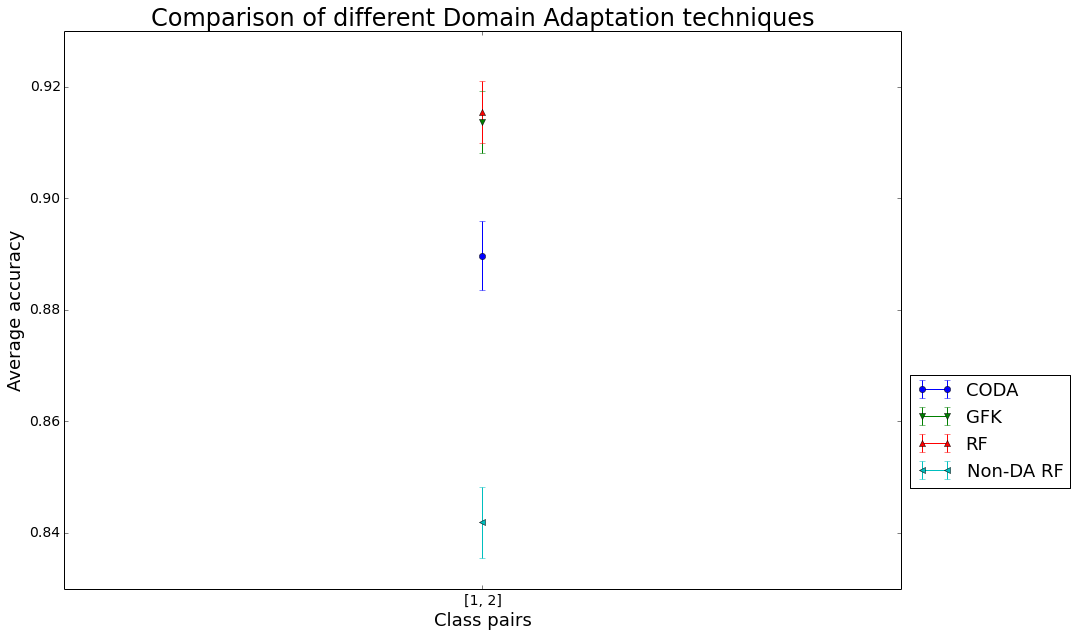

In [113]:
fig = plt.figure(figsize=(18.75,10))
ax = fig.add_subplot(111)
temp_score = np.array(scores_per_pair)
temp_score = temp_score[:,0]
temp_error = []
for index in range(0, len(scores_per_pair)):
    temp_error.append(sem(np.array(errorbars_per_pair[index][0]), axis = 1))
temp_error = np.array(temp_error)
labels = ['CODA','GFK','RF','Non-DA RF']
for index in range(0, len(temp_score[0])):
    ax.errorbar(range(0, len(temp_score)), temp_score[:,index], yerr=temp_error[:,index], 
                label=labels[index], marker = Line2D.filled_markers[index])    
ax.set_title("Comparison of different Domain Adaptation techniques", fontsize=24)
ax.set_xlabel("Class pairs",fontsize=18)
ax.set_ylabel("Average accuracy",fontsize=18)
ax.tick_params(axis='y', labelsize=14)
ax.set_xticks(range(0, len(temp_score)))
ax.set_xticklabels(Selected_pairs,fontsize=14)
ax.set_xlim(-0.5, len(temp_score)-0.5)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.4), fontsize=18)
#plt.savefig("../../Presentation/Compare_different_DA_techniques")
plt.show()

In [146]:
np.arange(0,0.35*4*3,0.35*4)

array([ 0. ,  1.4,  2.8])

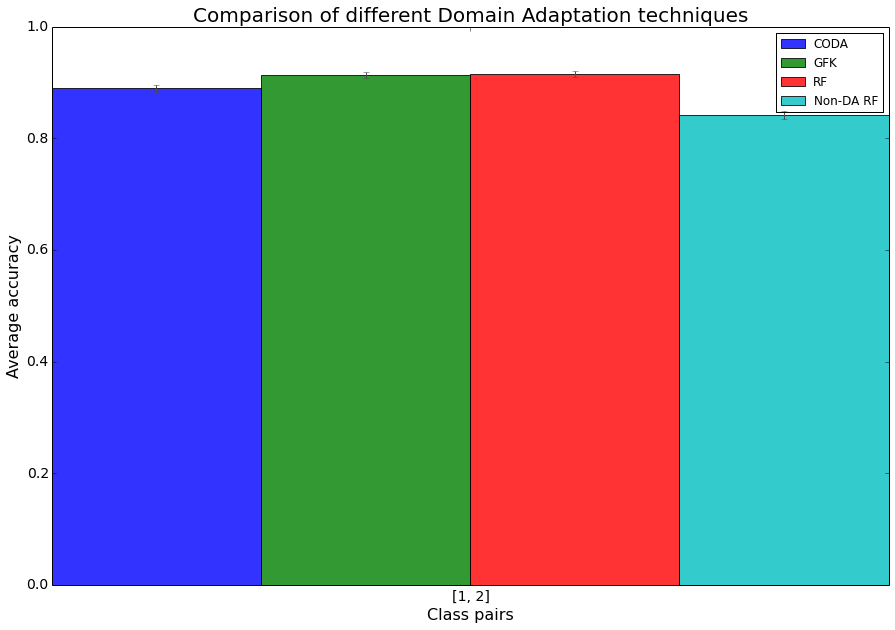

In [115]:
n_methods = 4
n_pairs = 1
bar_width = 0.35
gap = 1
index = np.arange(0, (bar_width*n_methods+gap)*n_pairs, bar_width*n_methods+gap)
opacity = 0.8
error_config = {'ecolor': '0.3'}
colors = ['b','g','r','c']
fig, ax = plt.subplots(figsize=(18.75,10))
for i in range(0,n_methods):
    rects1 = plt.bar(index+i*bar_width, temp_score[:,i], bar_width,
                     alpha=opacity,
                     color=colors[i],
                     yerr=temp_error[:,i],
                     error_kw=error_config,
                     label=labels[i])
    
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.4), fontsize=16)

plt.title('Comparison of different Domain Adaptation techniques', fontsize=20)
plt.xlabel('Class pairs', fontsize=16)
plt.ylabel('Average accuracy', fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
plt.xticks(index + n_methods*bar_width/2, Selected_pairs)
plt.legend()
plt.show()

In [116]:
pickle.dump([scores_per_pair, errorbars_per_pair, feature_importance_per_pair], open('GFK_CODA_RF_pair_1_2_balanced_source.p', "w" ))

----------------------END Plot the scores for each class pair using the four methods above----------------------

In [49]:
#plot feature importance
def plot_feature_importance(names, feature_matrix, title):
    for i in range(0,len(feature_matrix)):
        name = names[i]
        # Plot the feature importances of the forest
        plt.figure()
        plt.title(title+name)
        '''Boxplots'''
        data = np.array(feature_matrix[i][0])
        df = pd.DataFrame(data, columns=feature_labels[0:len_feature])
        med = df.median()
        med.sort()
        newdf = df[med.index]
        plt.boxplot(np.array(newdf),'',vert=False)
        plt.yticks(range(1,len_feature+1), med.index, rotation=0)
        plt.xlabel("Feature importance")
        plt.show()

-----------------------------------Plot the feature importance for certain pair of classes with three methods-----------------------------------

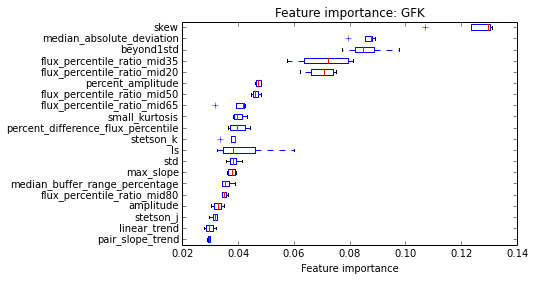

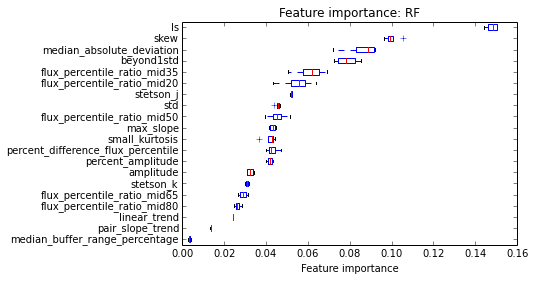

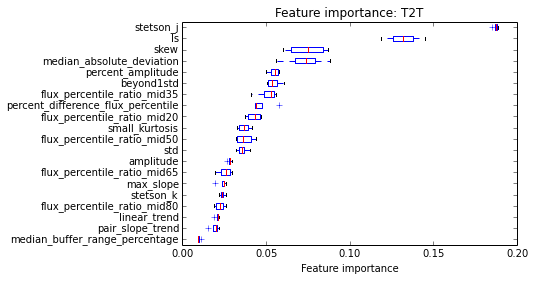

In [50]:
plot_feature_importance(['GFK','RF','T2T'], feature_importance_per_pair[0], 'Feature importance: ')

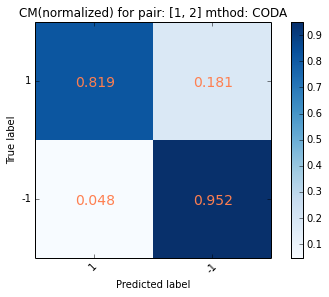

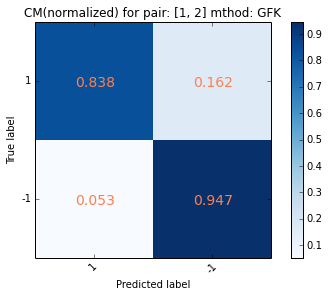

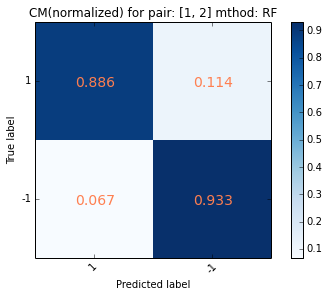

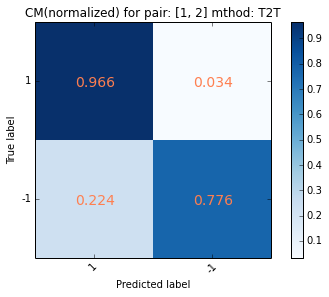

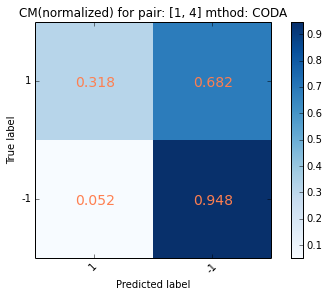

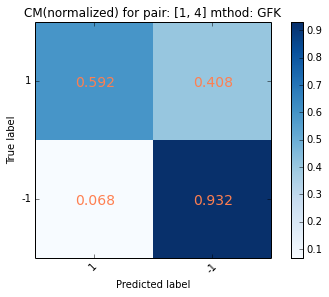

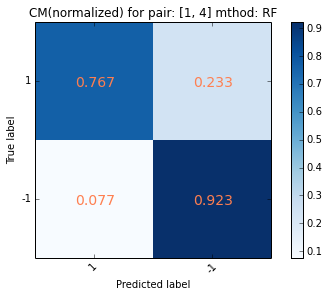

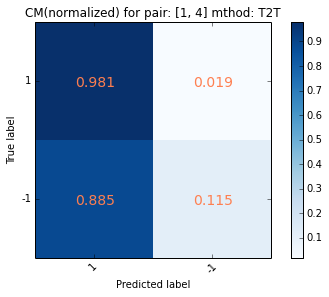

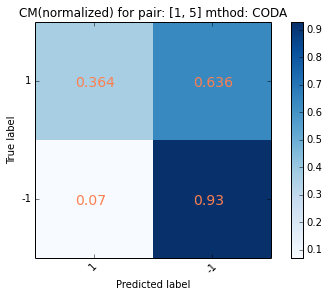

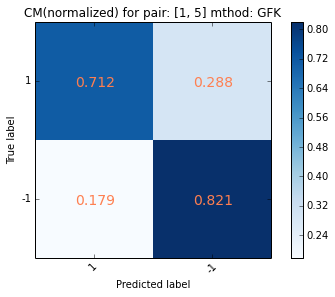

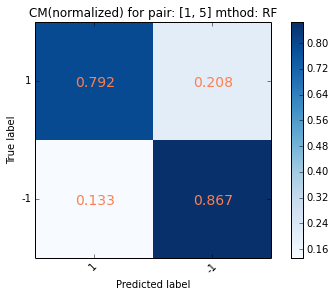

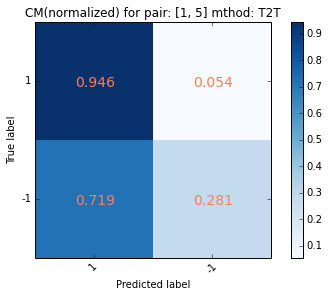

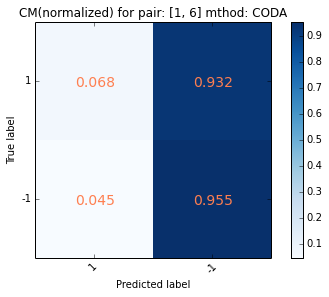

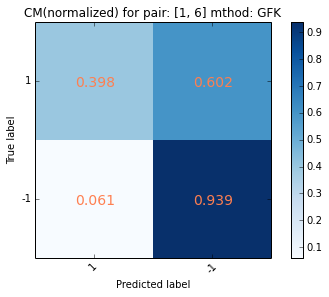

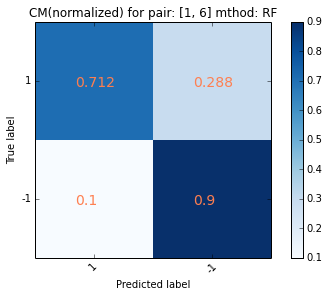

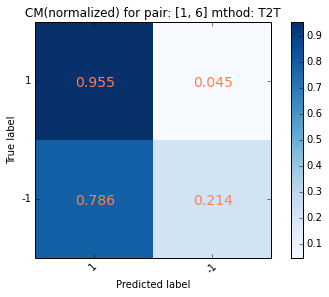

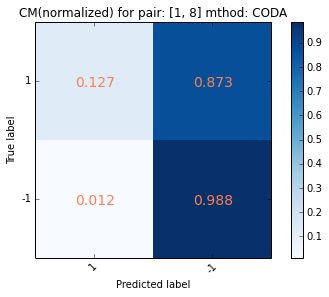

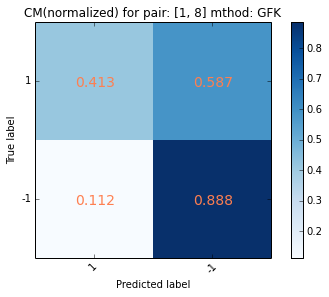

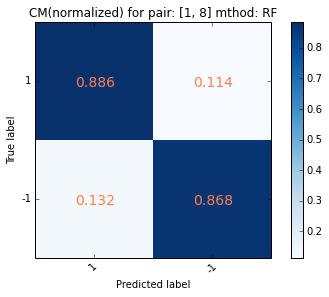

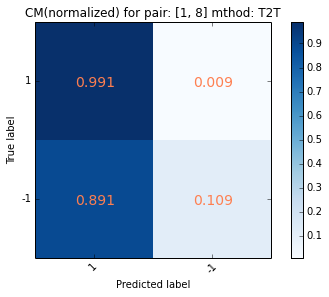

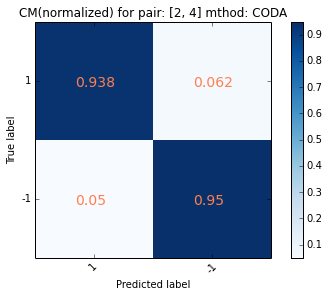

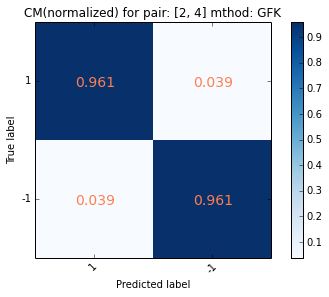

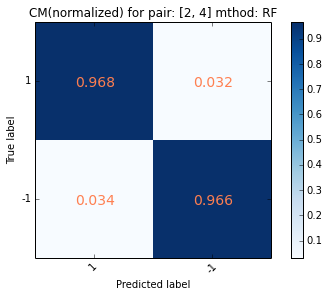

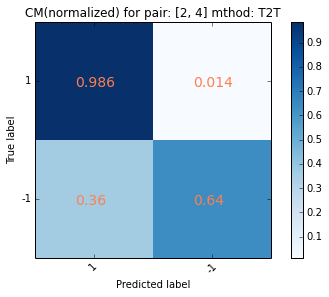

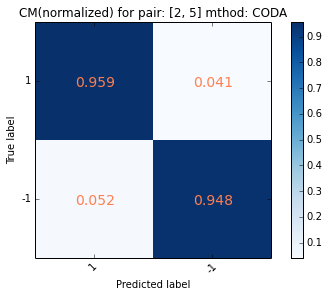

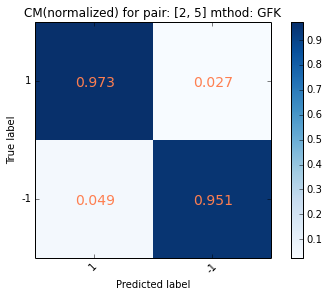

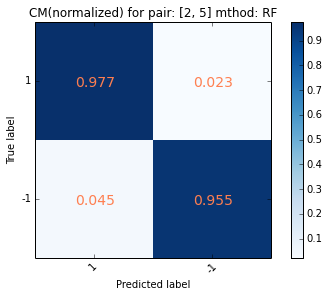

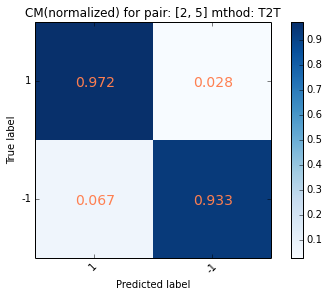

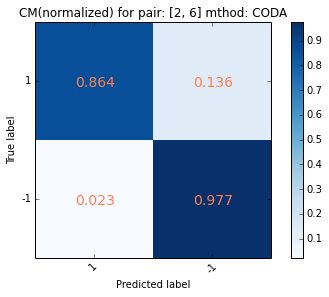

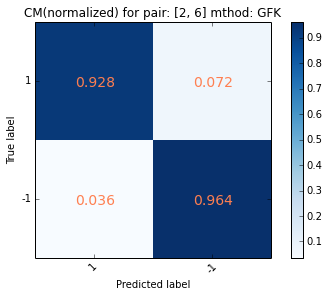

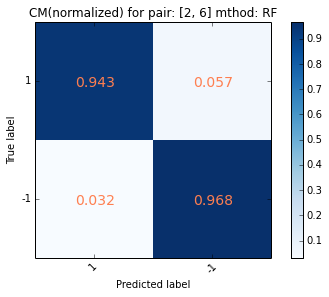

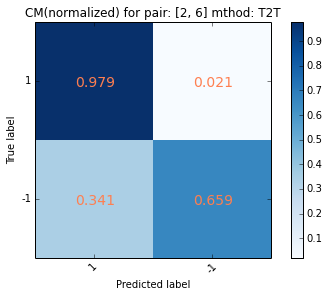

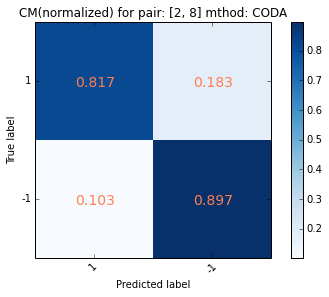

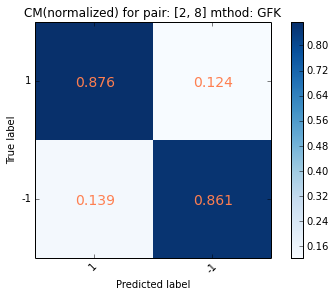

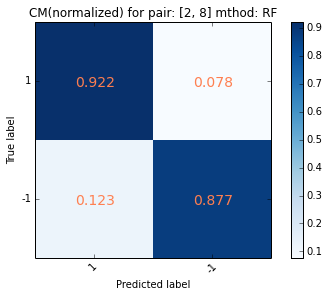

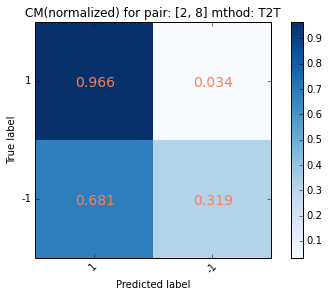

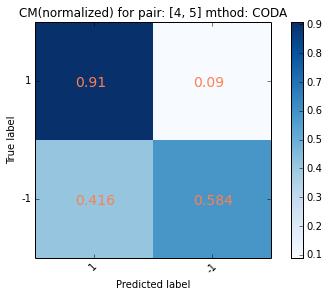

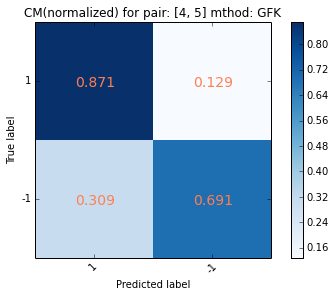

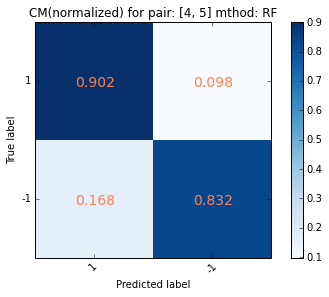

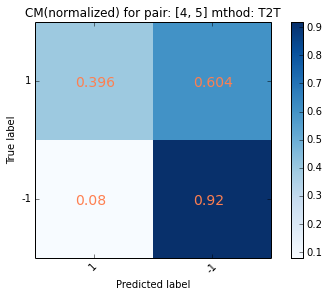

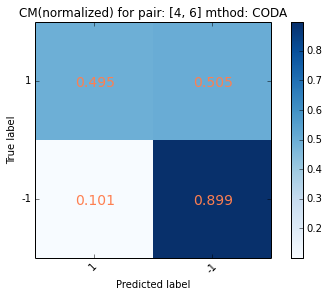

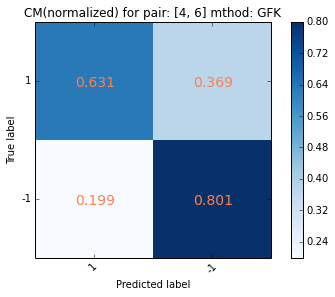

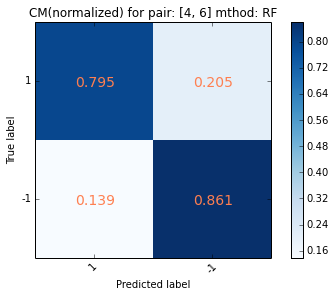

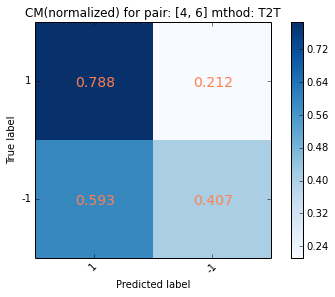

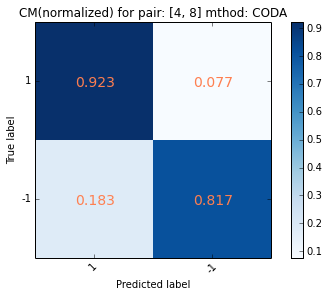

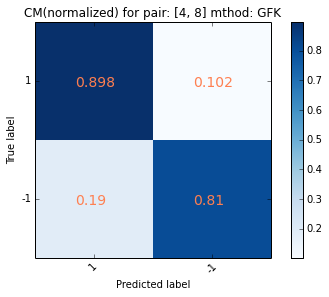

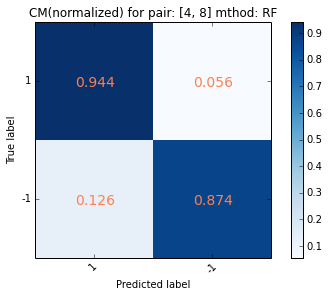

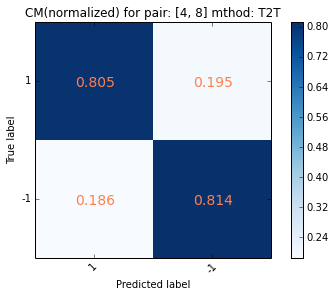

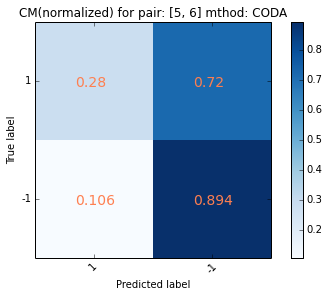

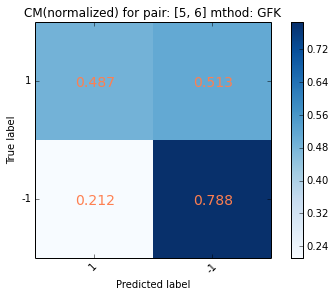

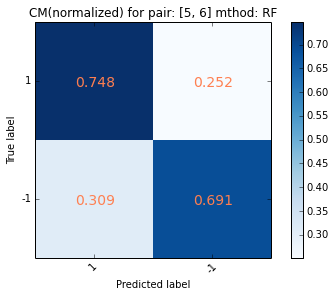

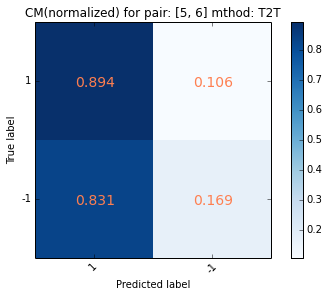

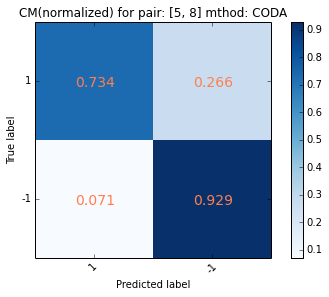

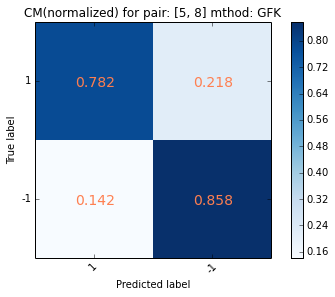

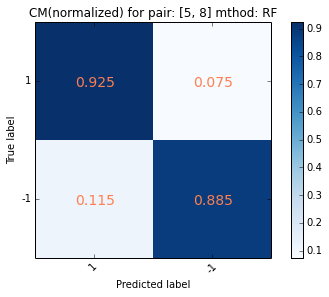

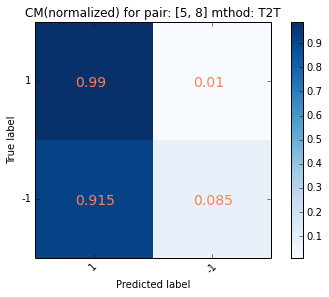

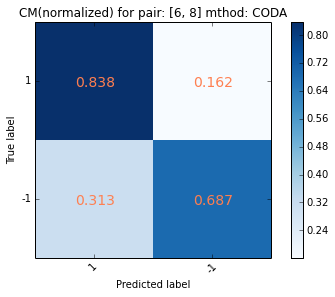

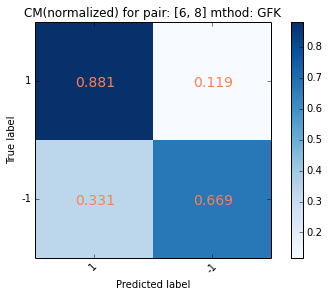

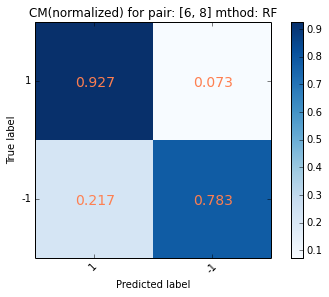

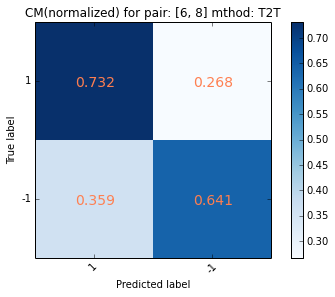

In [182]:
#confusion matrix
methods = ['CODA','GFK','RF','T2T']
for pair_index in range(len(Selected_pairs)):
    for method_index in range(len(methods)):
        cm = confusion_matrix(Y_tests_pairs[pair_index], Y_preds_pairs[pair_index][method_index])
        np.set_printoptions(precision=3)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.figure()
        filename = 'CM_%d_%d_%s' %(Selected_pairs[pair_index][0], Selected_pairs[pair_index][1], methods[method_index])
        plot_confusion_matrix(cm_normalized, filename,
                              'CM(normalized) for pair: %s method: %s' %(Selected_pairs[pair_index], 
                                                                        methods[method_index]))
        

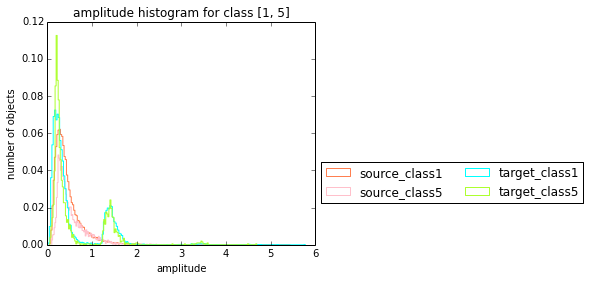

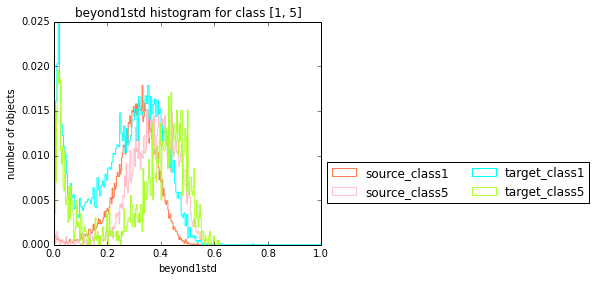

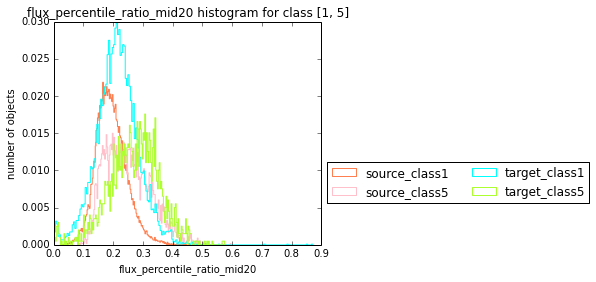

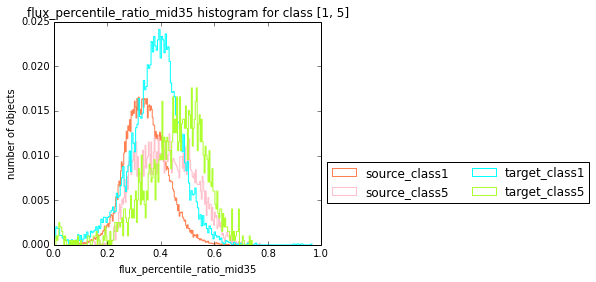

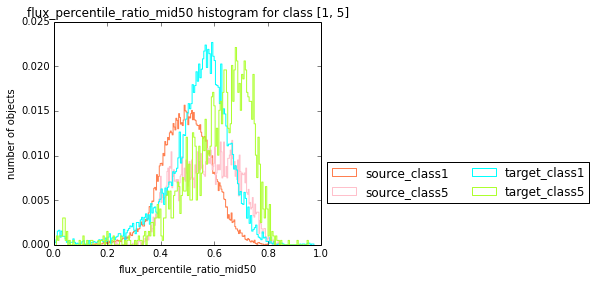

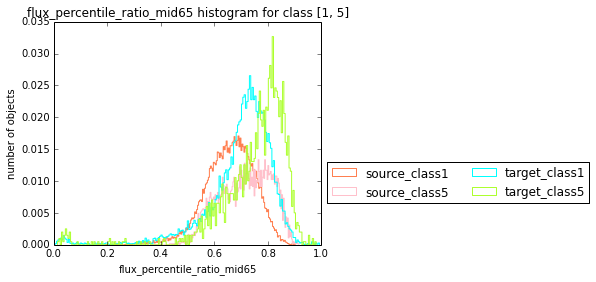

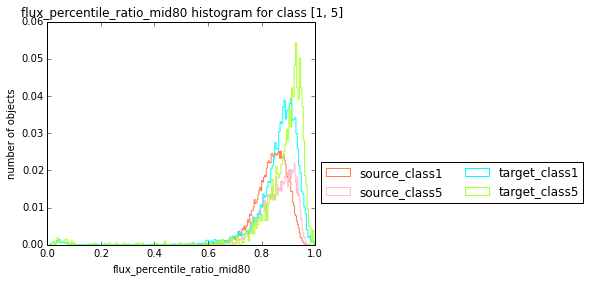

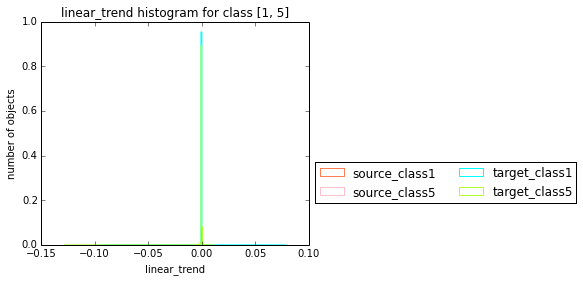

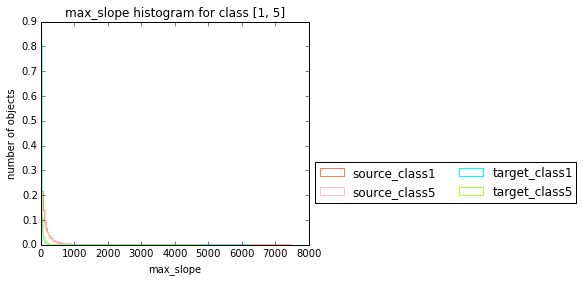

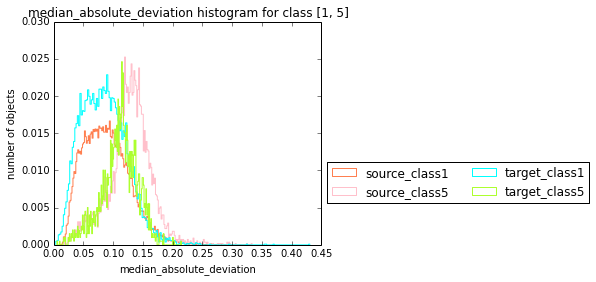

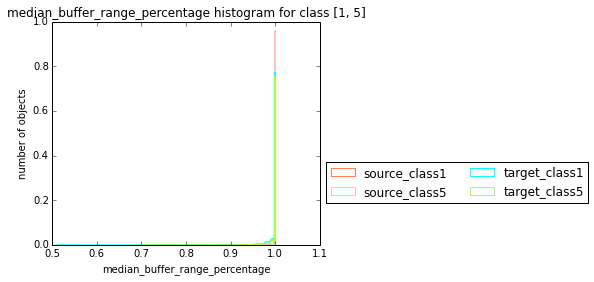

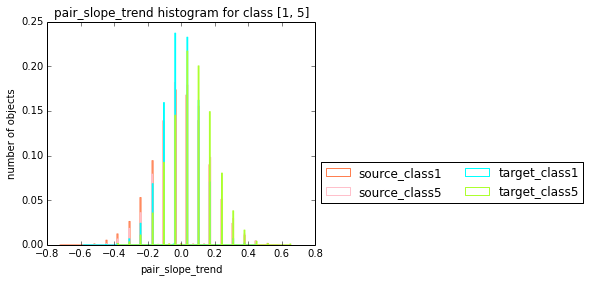

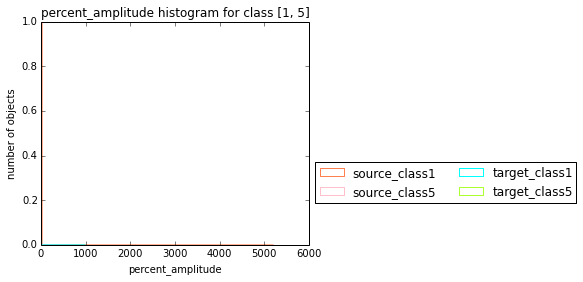

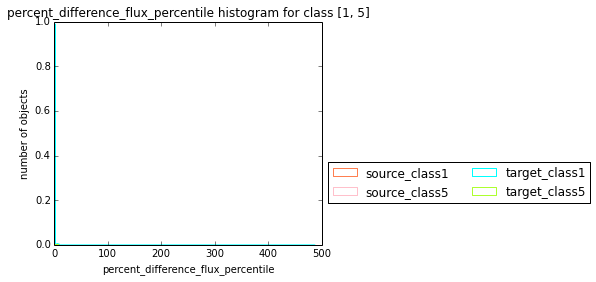

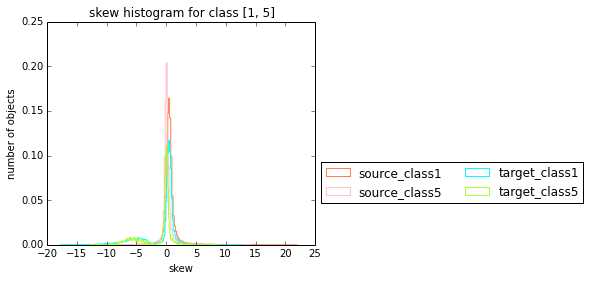

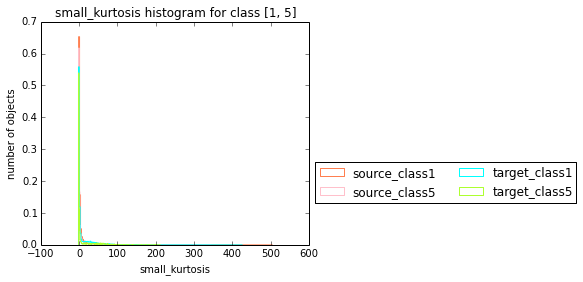

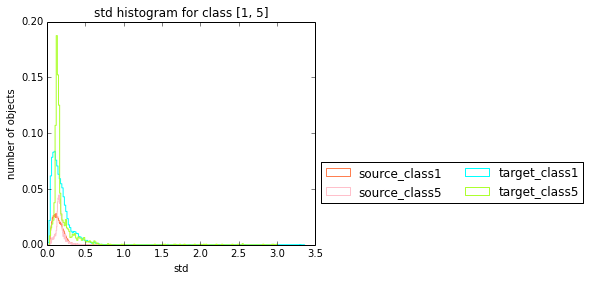

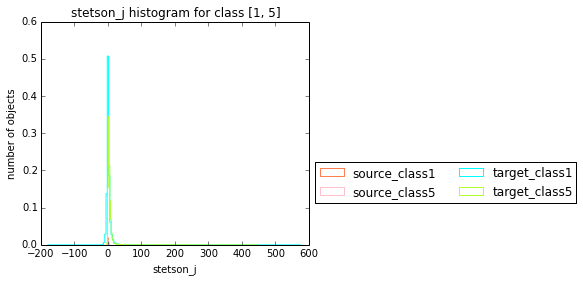

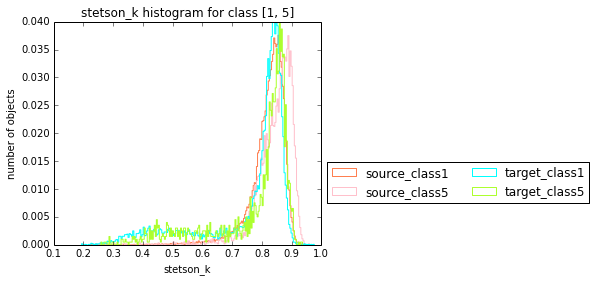

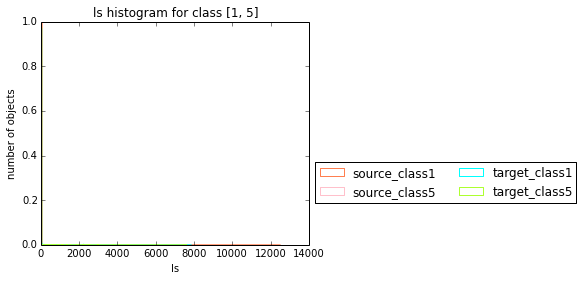

In [106]:
#plot histogram for each features based on certain classes
color_names = ['coral', 'pink', 'aqua', 'greenyellow', 'indigo', 'grey']
selected_pairs = [1, 5]
for feature in feature_labels[0:len_feature]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    index = 0
    for data, name in [(crts,'source'), (ptfr,'target')]:
        for c in selected_pairs:
            temp = (selectdata(data, [c]))[feature]
            weights = np.ones_like(temp)/len(temp)
            ax.hist(np.array(temp), bins =200, label = '%s_class%s' %(name, c), 
                    color=color_names[index], histtype='step', weights=weights)
            index = index +1
    ax.set_xlabel("%s" %feature)
    ax.set_ylabel("number of objects")
    box = ax.get_position()
    ax.set_title("%s histogram for class %s" %(feature, selected_pairs))
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0.4), ncol = 2)
    plt.savefig("feature_histogram/%s histogram for class %s" %(feature, selected_pairs), bbox_inches='tight')
    plt.show()

-----------------------------Find the index of outliers for certain feature with given class-----------------------------

In [81]:
def index_of_outliers(data, c, feature):
    temp = (selectdata(data, [c]))[feature]
    Q1 = np.percentile(temp, 25)
    Q3 = np.percentile(temp, 75)
    IQ = Q3-Q1
    return (temp.index[(temp > (Q3 + 3*IQ))|(temp < (Q1 - 3*IQ))]).values

In [100]:
for feature in feature_labels[0:len_feature]:
    outliers = []
    for c in selected_pairs:
        outliers.extend(index_of_outliers(ptfr, c, feature))
    outliers = list(set(outliers))
    np.savetxt("outliers_for_features/outliers_index_class%s_feature_%s" %(selected_pairs, feature), outliers, delimiter = ",")

-----------------------------END Find the index of outliers for certain feature with given class-----------------------------

In [32]:
myfile = open('scores_per_pair_crts_ptfr_unbalanced.csv', 'wb')
wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
wr.writerow(scores_per_pair)
myfile.close()

myfile = open('scores_w_errorbars_crts_ptfr_unbalanced.csv', 'wb')
wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
wr.writerow(errorbars_per_pair)
myfile.close()

In [33]:
print Selected_pairs
print scores_per_pair[14]
errorbars_15_pairs = errorbars_per_pair

[[1, 2], [1, 4], [1, 5], [1, 6], [1, 8], [2, 4], [2, 5], [2, 6], [2, 8], [4, 5], [4, 6], [4, 8], [5, 6], [5, 8], [6, 8]]
[[0.72727272727272729, 0.80303030303030309, 0.87121212121212122, 0.69570707070707083]]


In [13]:
savemat('CODA.mat', mdict={'dataX_norm1': dataX_norm1.T, 'dataX_norm2': dataX_norm2.T, 'labels': labels, 'idxLabs': idxLabs, 
                                    'idxUnls': idxUnls, 'idxTest': idxTest, 'idxSS': idxSS,
                                    'idxTT': idxTT})

----------------------------------Test if unbalancing class ratio or decreasing training data will affect training accuracy----------------------------------

In [11]:
mlab = Matlab(executable='/Applications/MATLAB_R2015a.app/bin/matlab')

In [12]:
tr_ratio = 0.5
un_ration = 0.3
test_ratio = 0.2
test_pair = [2, 5]
iter_time1 = 4
iter_time2 = 2
clf = rfc
Selected_Class = [1, -1]

In [13]:
mlab.start()
mlab_run_time = 0
scores_DA = []
errorbars_DA = []
for source, target in [(crts, ptfr)]:
    source = selectdata(source, test_pair)
    target = selectdata(target, test_pair)
    score_ratios = []
    errorbars_ratios = []
    for dec_ratio in reversed(range(20,105,20)):
        scores_per_comb = []
        errorbars = []
        for tag1, pair in [('diminish the objects in both classes', [2, 5]),
                          ('diminish the objects in the smaller class', [2])]:
            for tag2, dec_s, dec_t in [('both source domain and target domain', True, True), 
                                 ('just source domain', True, False), 
                                 ('just target domain', False, True)]: 
                print dec_ratio,tag1,'for',tag2,':'
                if dec_s:
                    temp = sample_wo_replacement_by_ratio(source, 1-dec_ratio/100, pair)
                    source_dec = source[~source.index.isin(temp.index.values)]
                else:
                    source_dec = source
                
                if dec_t:
                    temp = sample_wo_replacement_by_ratio(target, 1-dec_ratio/100, pair)
                    target_dec = target[~target.index.isin(temp.index.values)]
                else:
                    target_dec = target
                '''format source and target data, get num of smaller class, determine how many times shall we repeat (ratio)'''             
                source_dec, target_dec, test_smaller_class, ratio, larger_c = format_data(
                    source_dec, target_dec, test_pair)
                scores_CODA = []
                scores_GFK = []
                scores_RF = []
                scores_T2T = []
                target_tr_larger_index = []
                '''formulate data for CODA'''
                for i in range(ratio):    
                    '''Results for CODA'''
                    acc_CODA, dataX_norm1, labels, idxLabs, idxUnls, \
                    idxTest, dataLabTT, target_tr_larger_index, Y_pred_CODA = CODA(
                        source_dec, target_dec, tr_ratio, un_ration, test_ratio, 
                        test_smaller_class, larger_c, target_tr_larger_index, mlab)
                    mlab_run_time = mlab_run_time+1           
                    scores_CODA.append(acc_CODA)
                    print mlab_run_time

                    '''The results using the same data using GFK and random forest'''
                    acc_GFK, acc_RF, accT2T, Y_pred_GFK, Y_pred_RF, Y_pred_T2T = GFK_RF(dataX_norm1, labels, idxLabs, idxUnls, idxTest, dataLabTT, mlab)
                    mlab_run_time = mlab_run_time+1
                    scores_GFK.append(acc_GFK)
                    scores_RF.append(acc_RF)
                    scores_T2T.append(accT2T)
                    mlab.stop()
                    mlab.start()
                errorbars.append([scores_CODA, scores_GFK, scores_RF, scores_T2T])
                tags_comb_score = [1-np.mean(scores_CODA), np.mean(scores_GFK), np.mean(scores_RF), np.mean(scores_T2T)]
                scores_per_comb.append(tags_comb_score)
                print tags_comb_score
        score_ratios.append(scores_per_comb)
        errorbars_ratios.append(errorbars)
    scores_DA.append(score_ratios)
    errorbars_DA.append(errorbars_ratios)
mlab.stop()

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-a7c8e6d6-c28a-4aac-b81e-3d6f9408c4b7
Send 'exit' command to kill the server
........MATLAB started and connected!
100 diminish the objects in both classes for both source domain and target domain :
1
MATLAB closed
Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-a7c8e6d6-c28a-4aac-b81e-3d6f9408c4b7
Send 'exit' command to kill the server
......MATLAB started and connected!
3
MATLAB closed
Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-a7c8e6d6-c28a-4aac-b81e-3d6f9408c4b7
Send 'exit' command to kill the server
.......MATLAB started and connected!
[0.94542772861356927, 0.96478613569321525, 0.97105457227138636, 0.96275811209439521]
100 diminish the objects in both classes for just source domain :
5
MATLAB closed
Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-a7c8e6d6-c28a-4aac-b81e-3d6f9408c4b7
Send 'exit' command to kill the server
.......MATLAB started and connected!
7
MATLAB closed
Starting MATLAB on ZMQ socket ipc:///

/Library/Python/2.7/site-packages/pandas/core/indexing.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


True

In [14]:
i = 1
text_notes = []
for tag1, pair in [('diminish the objects in both classes', [2, 5]),
                          ('diminish the objects in the smaller class', [2])]:
    for tag2, dec_s, dec_t in [('both source domain and target domain', True, True), 
                                 ('just source domain', True, False), 
                                 ('just target domain', False, True)]: 
        text_notes.append("Tag%d: %s for %s" %(i,tag1,tag2))
        i = i+1
text_notes = '\n'.join(text_notes)

In [16]:
errorbars_values = errorbars_DA[0]
print (np.max(errorbars_values[3][5], axis = 1) - np.min(errorbars_values[3][5], axis = 1))/2
print len(errorbars_values[3][5])

[ 0.02407407  0.01851852  0.01898148  0.01388889]
4


[ 0.00516224  0.00415129  0.01600985  0.00185185  0.        ]
[ 0.00101401  0.00392066  0.0033867   0.00231481  0.00326493]
[ 0.00082965  0.00322878  0.00354064  0.00347222  0.00419776]
[ 0.00018437  0.00426661  0.00400246  0.00462963  0.0051306 ]


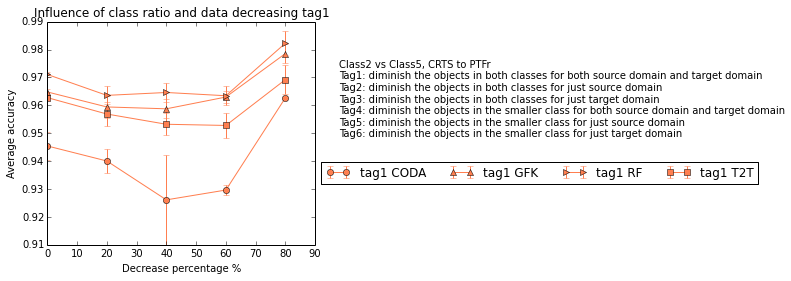

[ 0.          0.00073746  0.00553097  0.00147493  0.00184366]
[ 0.00258112  0.00036873  0.00175147  0.00073746  0.00165929]
[ 0.00119838  0.00212021  0.00331858  0.00018437  0.00092183]
[  9.21828909e-05   4.51696165e-03   9.21828909e-04   6.45280236e-04
   1.56710914e-03]


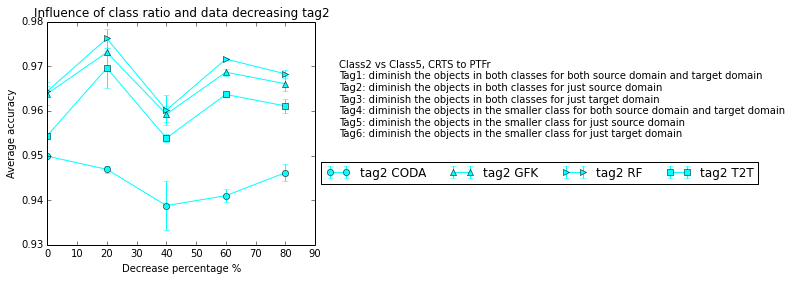

[ 0.00516224  0.00369004  0.00862069  0.00648148  0.        ]
[ 0.00294985  0.00034594  0.00215517  0.00277778  0.        ]
[ 0.00212021  0.00138376  0.          0.00115741  0.00606343]
[ 0.00359513  0.00219096  0.00015394  0.00578704  0.00746269]


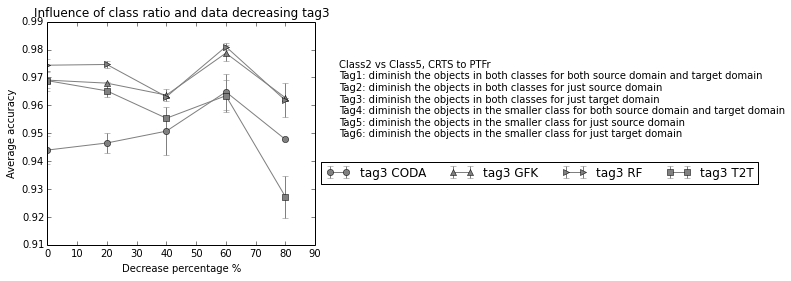

[ 0.00442478  0.00092251  0.00615764  0.00648148  0.01865672]
[ 0.00073746  0.00161439  0.00431034  0.00324074  0.00886194]
[  2.77555756e-17   2.07564576e-03   3.23275862e-03   5.32407407e-03
   7.46268657e-03]
[  1.75147493e-03   4.61254613e-04   2.00123153e-03   2.77555756e-17
   6.52985075e-03]


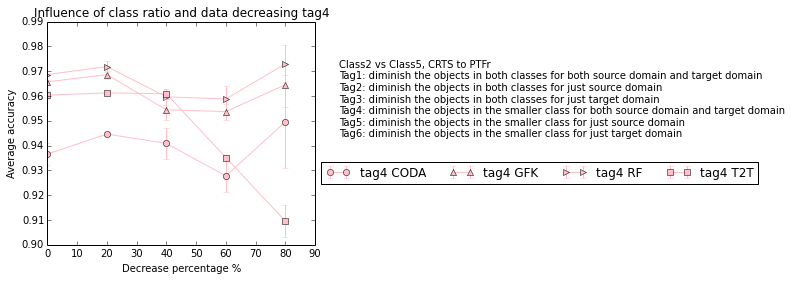

[ 0.00479351  0.          0.00110619  0.00110619  0.00036873]
[  1.65929204e-03   0.00000000e+00   9.21828909e-05   7.37463127e-04
   1.47492625e-03]
[ 0.00276549  0.00082965  0.00119838  0.00193584  0.00285767]
[ 0.00018437  0.0005531   0.00165929  0.00046091  0.00138274]


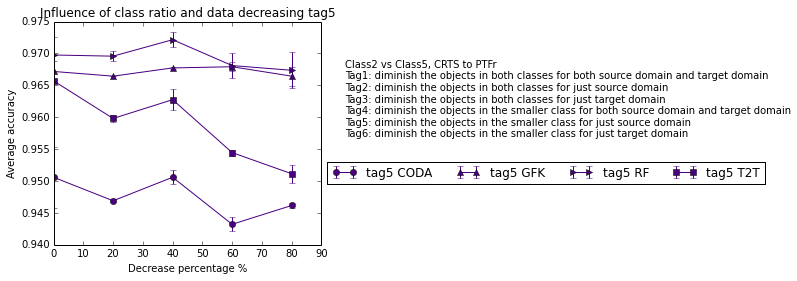

[ 0.00110619  0.00184502  0.00184729  0.01203704  0.00746269]
[ 0.00082965  0.00092251  0.00138547  0.00925926  0.00886194]
[ 0.00027655  0.00149908  0.0041564   0.00949074  0.01026119]
[ 0.00082965  0.00530443  0.00153941  0.00694444  0.00746269]


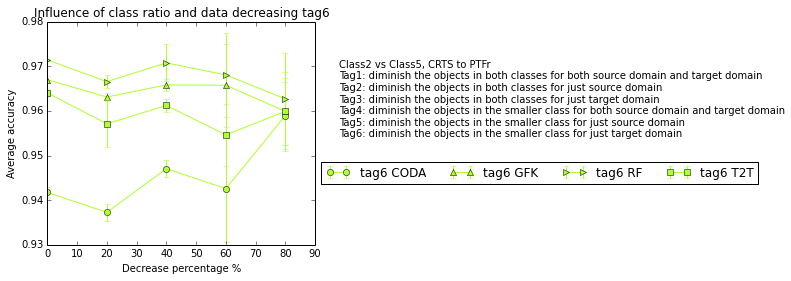

In [40]:
len(score_ratios)
tags = 6
errorbars_values = errorbars_DA[0]
methods = ['CODA','GFK','RF','T2T']
color_names = ['coral', 'aqua', 'grey', 'pink', 'indigo', 'greenyellow']
for m_index in range(6):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for tag_index in range(m_index, m_index+1):
        accuracies = []
        errors = []
        for ratio_index in range(5):
            accuracies.append(score_ratios[ratio_index][tag_index])
            temp = errorbars_values[ratio_index][tag_index]
            
            temp_error = sem(temp, axis = 1)
            temp_error = (np.max(temp, axis = 1) - 
                          np.min(temp, axis = 1))/len(temp)
            
            errors.append(temp_error)
        accuracies = np.array(accuracies)
        errors = np.array(errors)
        i = 0
        for method_index in range(4):
            print errors[:,method_index]
            ax.errorbar(range(0,85,20), accuracies[:,method_index], yerr=errors[:,method_index], 
                label="tag%d %s" % (tag_index+1, methods[method_index]), 
                        color = color_names[tag_index], marker = Line2D.filled_markers[i])
            '''
            ax.plot(range(20,85,20), accuracies[:,method_index], "s-", label="tag%d %s" % 
                    (tag_index+1, methods[method_index]), 
                    color = color_names[tag_index], marker = Line2D.filled_markers[i])
            '''
            i = i+2

    ax.set_title("Influence of class ratio and data decreasing tag%d" %(m_index+1))
    ax.set_xlabel("Decrease percentage %")
    ax.set_ylabel("Average accuracy")

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0.4), ncol = 6)
    fig.text(.8,.5, "%s \n%s" %("Class2 vs Class5, CRTS to PTFr",text_notes))
    #plt.savefig("Influence_of_class_ratio_and_data_decreasing/%s.png" %methods[m_index], bbox_inches='tight')
    plt.savefig("Influence_of_class_ratio_and_data_decreasing/Tag%d.png" %(m_index+1), bbox_inches='tight')
    plt.show()

In [25]:
print "%s \n%s" %("Class2 vs Class5, CRTS to PTFr",text_notes)

Class2 vs Class5, CRTS to PTFr 
Tag1: diminish the objects in both classes for both source domain and target domain
Tag2: diminish the objects in both classes for just source domain
Tag3: diminish the objects in both classes for just target domain
Tag4: diminish the objects in the smaller class for both source domain and target domain
Tag5: diminish the objects in the smaller class for just source domain
Tag6: diminish the objects in the smaller class for just target domain
